# Wandb Data Analysis

In [1]:
import wandb
import os

wandb.login(key=os.environ.get("WANDB_API_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/paul/.netrc
wandb: Currently logged in as: paul-erpenstein (wandb-erpenstein) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import pandas as pd

pull_data = False
PROJECT = "final-gs-on-a-budget"

api = wandb.Api()

runs = api.runs(f"{PROJECT}")

if pull_data:
    data = []
    for run in runs:
        row = {
            "run_id": run.id,
            "name": run.name,
            "state": run.state,
            "created_at": run.created_at,
            **run.config,  # Get run config parameters
            **run.summary,  # Get final metrics (like loss, accuracy, etc.)
        }
        data.append(row)

    df_runs = pd.DataFrame(data)

    df_runs.to_csv("data/wandb_runs.csv", index=False)

In [3]:
df_runs = pd.read_csv("data/wandb_runs.csv")

In [4]:
df_runs["dataset_name"] = df_runs["name"].apply(lambda x: x.split("-")[1])
df_runs["technique"] = df_runs["name"].apply(lambda x: x.split("-")[0])
df_runs["size"] = df_runs["name"].apply(lambda x: x.split("-")[2])

### Which facets of the data have too many runs associated with them?

In [5]:
multiple_runs = df_runs.groupby(["dataset_name", "size", "technique"])["run_id"].count()
multiple_runs[multiple_runs > 1]

dataset_name  size      technique     
truck         extended  default           2
                        mcmc              2
              high      default           2
                        eagles            2
                        gaussian_pro      2
                        geo_gaussian      2
                        mcmc              2
                        mini_splatting    2
                        mip_splatting     2
              low       default           3
                        eagles            2
                        gaussian_pro      2
                        geo_gaussian      2
                        mcmc              2
                        mini_splatting    2
                        mip_splatting     2
              medium    default           2
                        eagles            2
                        gaussian_pro      2
                        geo_gaussian      2
                        mcmc              2
                        mini_splattin

### Which are the runs that I actually require to analyze?

In [6]:
def get_latest_run_per_facet(df: pd.DataFrame) -> pd.DataFrame:
    rows = []

    for dataset in ["truck", "room", "stump"]:
        for size in ["low", "medium", "high"]:
            for technique in df["technique"].unique():
                rows.append(
                    df[
                        (df["dataset_name"] == dataset)
                        & (df["size"] == size)
                        & (df["technique"] == technique)
                    ].sort_values("created_at", ascending=False).iloc[0]
                )
    
    return pd.concat(rows, axis=1).transpose()

runs_to_analyze = get_latest_run_per_facet(df_runs)
runs_to_analyze

run_id                         name     state  \
33                          k22pnjso             mcmc-truck-low-1  finished   
29                          umm395kx          default-truck-low-1  finished   
93  bfba2f4fa825195992417ee2696a25bf   mini_splatting-truck-low-2  finished   
94  c7ed0ba2aa47a3030032f15f49f222ae    mip_splatting-truck-low-2  finished   
95  44c3332e0789b983a5d93367c657b60f           eagles-truck-low-2  finished   
..                               ...                          ...       ...   
87  ea0f6936dcd8e24145ea33618dec612f  mini_splatting-stump-high-1  finished   
91  5a2745ca052b6fa3c131bb5974da9c3d   mip_splatting-stump-high-1  finished   
71  4867c4da20de43a85bea5f43512e1a34          eagles-stump-high-1  finished   
75  f5d19e83a1abc01e7247756e1bab37a9    gaussian_pro-stump-high-1  finished   
79  3218280942293709639150240ec4b0f0    geo_gaussian-stump-high-1  finished   

              created_at     _runtime  _step         _timestamp  \
33  2025-01-17T00:57:34Z  1690.067736  30000  1737077063.969009   
29  2025-01-16T15:38:55Z  1599.125979  30000  1737043454.283376   
93  2025-02-11T18:27:06Z  1087.606485  30000  1739299513.653862   
94  2025-02-11T18:47:13Z  1018.095085  30000  1739300650.727693   
95  2025-02-11T20:07:57Z   908.761631  30000  1739305384.803288   
..                   ...          ...    ...                ...   
87  2025-01-17T04:38:51Z  1221.053574  30000  1737276035.085856   
91  2025-01-17T04:47:35Z  1417.500854  30000   1737288278.51617   
71  2025-01-17T03:44:29Z  1163.159359  30000  1737275953.933852   
75  2025-01-17T03:52:52Z  1490.511258  30000   1737087461.89266   
79  2025-01-17T04:14:52Z  1954.793746  30000  1737089246.351359   

   _wandb.runtime cum_created cum_deleted  ... propagated_iteration_after  \
33           1690      226523      226523  ...                        NaN   
29           1599      131494      132039  ...                        NaN   
93           1087      178113      178211  ...                        NaN   
94           1018      101310      101490  ...                        NaN   
95            908      104213      121170  ...                        NaN   
..            ...         ...         ...  ...                        ...   
87             37     2625081     1564631  ...                        NaN   
91             43     1771279      711073  ...                        NaN   
71             36     2119820     1215459  ...                        NaN   
75           1490     2049451      989297  ...                    12000.0   
79           1954     2141518     1313383  ...                        NaN   

   propagated_iteration_begin propagation_interval sky_seg sparse_loss  \
33                        NaN                  NaN     NaN         NaN   
29                        NaN                  NaN     NaN         NaN   
93                        NaN                  NaN     NaN         NaN   
94                        NaN                  NaN     NaN         NaN   
95                        NaN                  NaN     NaN         NaN   
..                        ...                  ...     ...         ...   
87                        NaN                  NaN     NaN         NaN   
91                        NaN                  NaN     NaN         NaN   
71                        NaN                  NaN     NaN         NaN   
75                     1000.0                 20.0   False       False   
79                        NaN                  NaN     NaN         NaN   

   scene_scale_lr_init sparse_num dataset_name       technique  size  
33                 NaN        NaN        truck            mcmc   low  
29                 NaN        NaN        truck         default   low  
93                 NaN        NaN        truck  mini_splatting   low  
94                 NaN        NaN        truck   mip_splatting   low  
95                 NaN        NaN        truck          eagles   low  
..                 ...        ...   

In [7]:
runs_to_analyze[(runs_to_analyze["dataset_name"] == "truck") & (runs_to_analyze["size"] == "low")][["name", "created_at", "n_gaussians"]]

name            created_at n_gaussians
33            mcmc-truck-low-1  2025-01-17T00:57:34Z      117856
29         default-truck-low-1  2025-01-16T15:38:55Z      117311
93  mini_splatting-truck-low-2  2025-02-11T18:27:06Z      117758
94   mip_splatting-truck-low-2  2025-02-11T18:47:13Z      117676
95          eagles-truck-low-2  2025-02-11T20:07:57Z      100899
96    gaussian_pro-truck-low-2  2025-02-11T20:24:02Z      117633
97    geo_gaussian-truck-low-2  2025-02-11T21:51:00Z      117307

In [8]:
runs_to_analyze[(runs_to_analyze["dataset_name"] == "stump") & (runs_to_analyze["size"] == "low")][["name", "created_at", "n_gaussians"]]

name            created_at n_gaussians
82            mcmc-stump-low-1  2025-01-17T04:19:40Z      117856
65         default-stump-low-1  2025-01-17T03:17:22Z      117160
85  mini_splatting-stump-low-1  2025-01-17T04:34:33Z      117706
89   mip_splatting-stump-low-1  2025-01-17T04:43:16Z      117447
69          eagles-stump-low-1  2025-01-17T03:40:20Z      100767
73    gaussian_pro-stump-low-1  2025-01-17T03:48:41Z      117530
77    geo_gaussian-stump-low-1  2025-01-17T04:12:50Z      117216

### Save a subset of the training statistics...

In [ ]:
pull_data = False

if pull_data:
    runs = []
    for run_id, dataset_name, technique, size in zip(
        runs_to_analyze["run_id"].values,
        runs_to_analyze["dataset_name"].values,
        runs_to_analyze["technique"].values,
        runs_to_analyze["size"].values,
    ):
        run = api.run(f"{PROJECT}/{run_id}")
        df_run = run.history(keys=["train/ssim", "train/psnr", "n_gaussians", "cum_deleted", "cum_created"])
        df_run["dataset_name"] = dataset_name
        df_run["technique"] = technique
        df_run["size"] = size
        runs.append(df_run)

    df_run = pd.concat(runs, axis=0)

    df_run.to_parquet("data/training_statistics.parquet")

In [10]:
df_training_stats = pd.read_parquet("data/training_statistics.parquet")

In [11]:
df_training_stats

_step  train/ssim  train/psnr  n_gaussians  cum_deleted  cum_created  \
0       60    0.392457    9.397554     117856.0          0.0          0.0   
1       98    0.489649    9.914223     117856.0          0.0          0.0   
2      213    0.438668   11.953866     117856.0          0.0          0.0   
3      285    0.460405   13.370628     117856.0          0.0          0.0   
4      339    0.519164   13.131285     117856.0          0.0          0.0   
..     ...         ...         ...          ...          ...          ...   
495  29807    0.708804   22.998547     860184.0    1313383.0    2141518.0   
496  29887    0.776217   27.483253     860184.0    1313383.0    2141518.0   
497  29941    0.714688   25.935402     860184.0    1313383.0    2141518.0   
498  29954    0.812200   28.204796     860184.0    1313383.0    2141518.0   
499  29955    0.728083   23.915722     860184.0    1313383.0    2141518.0   

    dataset_name     technique  size  
0          truck          mcmc   low  
1          truck          mcmc   low  
2          truck          mcmc   low  
3          truck          mcmc   low  
4          truck          mcmc   low  
..           ...           ...   ...  
495        stump  geo_gaussian  high  
496        stump  geo_gaussian  high  
497        stump  geo_gaussian  high  
498        stump  geo_gaussian  high  
499        stump  geo_gaussian  high  

[31500 rows x 9 columns]

### Pull the test statistics...

In [ ]:
pull_data = False

if pull_data:
    runs = []
    for run_id, dataset_name, technique, size in zip(
        runs_to_analyze["run_id"].values,
        runs_to_analyze["dataset_name"].values,
        runs_to_analyze["technique"].values,
        runs_to_analyze["size"].values,
    ):
        run = api.run(f"{PROJECT}/{run_id}")
        df_run = run.history(keys=["test_full/ssim", "test_full/psnr"])
        df_run["dataset_name"] = dataset_name
        df_run["technique"] = technique
        df_run["size"] = size
        runs.append(df_run)

    df_run = pd.concat(runs, axis=0)

    df_run.to_parquet("data/test_statistics.parquet")

In [13]:
df_test_stats = pd.read_parquet("data/test_statistics.parquet")

In [14]:
df_test_stats

_step  test_full/ssim  test_full/psnr dataset_name     technique  size
0     500        0.596729       15.807237        truck          mcmc   low
1    1000        0.676081       19.094009        truck          mcmc   low
2    1500        0.701434       20.109855        truck          mcmc   low
3    2000        0.712163       20.520590        truck          mcmc   low
4    2500        0.719182       20.811629        truck          mcmc   low
..    ...             ...             ...          ...           ...   ...
55  28000        0.679788       23.256035        stump  geo_gaussian  high
56  28500        0.680524       23.315898        stump  geo_gaussian  high
57  29000        0.680591       23.276541        stump  geo_gaussian  high
58  29500        0.679724       23.223272        stump  geo_gaussian  high
59  30000        0.680399       23.259621        stump  geo_gaussian  high

[3780 rows x 6 columns]

### Visualize a training curve...

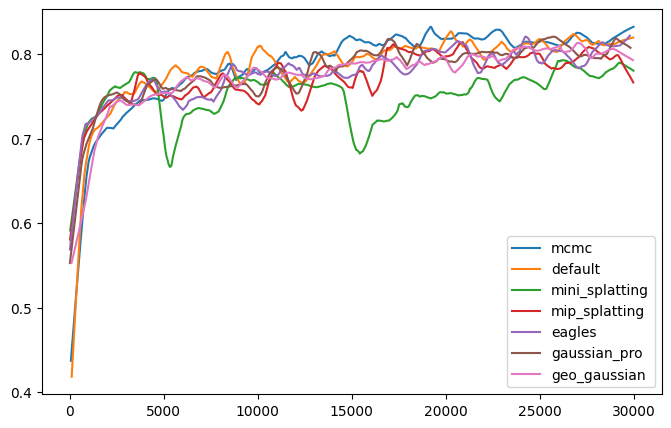

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm


def plot_single_facet_curve(
    df: pd.DataFrame,
    dataset_name: str,
    size: str,
    col: str,
    smooth_frac: float = 0.0,
    ax: plt.Axes | None = None,
) -> None:
    facet_df = df[((df["dataset_name"] == dataset_name) & (df["size"] == size))]

    if ax is None:
        plt.figure(figsize=(8, 5))
    for technique in facet_df["technique"].unique():
        subset = facet_df[(facet_df["technique"] == technique)]
        if smooth_frac > 0:
            lowess = sm.nonparametric.lowess(subset[col], subset["_step"], frac=smooth_frac)
            sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], label=technique, ax=ax)
        else:
            sns.lineplot(x=subset["_step"], y=subset[col], label=technique, ax=ax)

    if ax is None:
        plt.show()


plot_single_facet_curve(df_training_stats, "truck", "low", "train/ssim", smooth_frac=0.05)

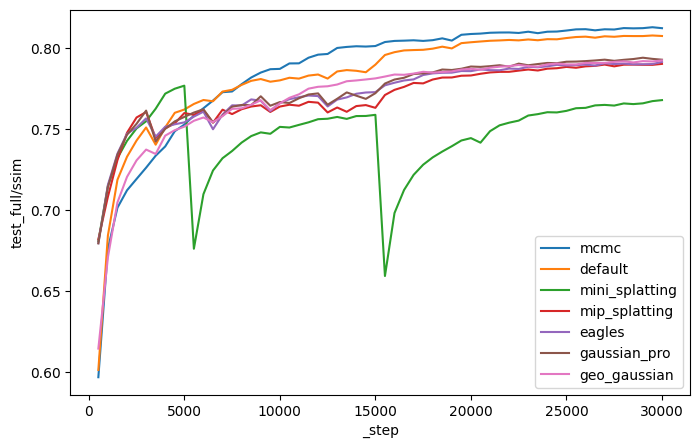

In [16]:
plot_single_facet_curve(df_test_stats, "truck", "low", "test_full/ssim")

### Contrast train and test statistics...

In [17]:
def contrast_train_and_test_progress(
    df_train: pd.DataFrame, df_test: pd.DataFrame, dataset_name: str, size: str
) -> None:
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    plot_single_facet_curve(
        df_train, dataset_name, size, "train/ssim", smooth_frac=0.05, ax=axs[0][0]
    )
    axs[0][0].set_ylabel("train/ssim")
    plot_single_facet_curve(df_test, dataset_name, size, "test_full/ssim", ax=axs[0][1])
    axs[0][1].set_ylabel("test_full/ssim")
    plot_single_facet_curve(
        df_train, dataset_name, size, "train/psnr", smooth_frac=0.05, ax=axs[1][0]
    )
    axs[1][0].set_ylabel("train/psnr")
    plot_single_facet_curve(df_test, dataset_name, size, "test_full/psnr", ax=axs[1][1])
    axs[1][1].set_ylabel("test_full/psnr")
    fig.suptitle(f"Training statistics: {dataset_name} - {size}")
    plt.show()

### Contrast and compare truck dataset

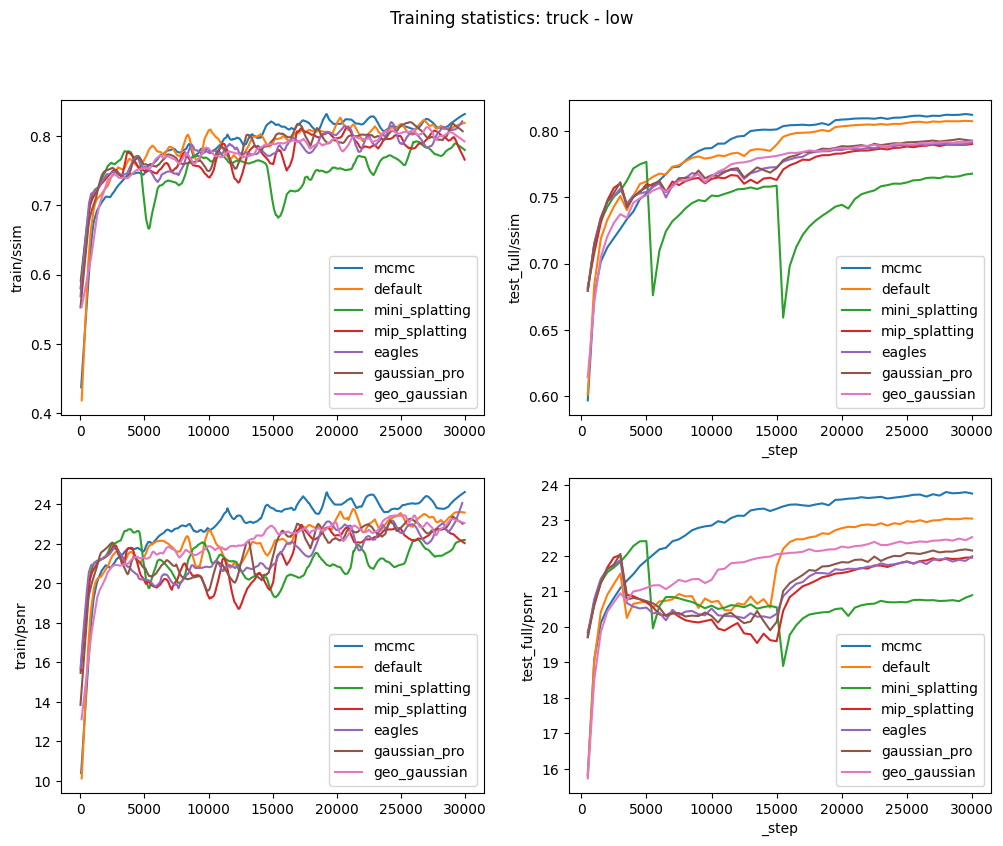

In [18]:
contrast_train_and_test_progress(df_training_stats, df_test_stats, "truck", "low")

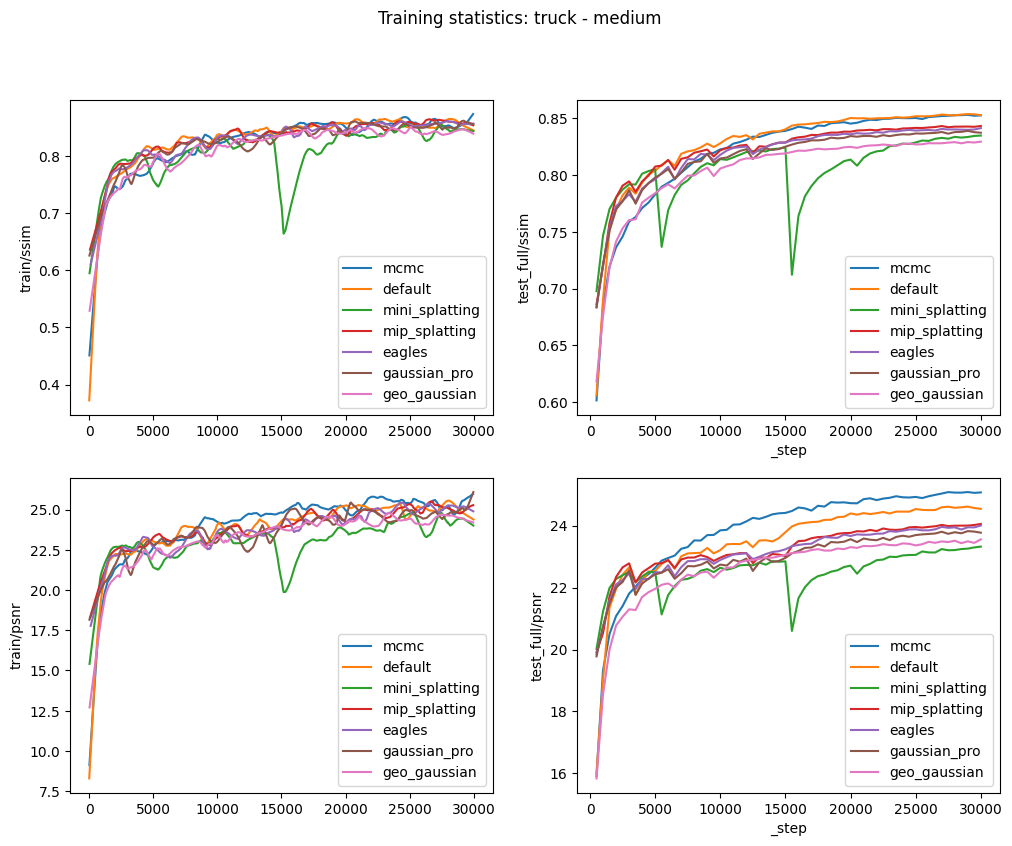

In [19]:
contrast_train_and_test_progress(df_training_stats, df_test_stats, "truck", "medium")

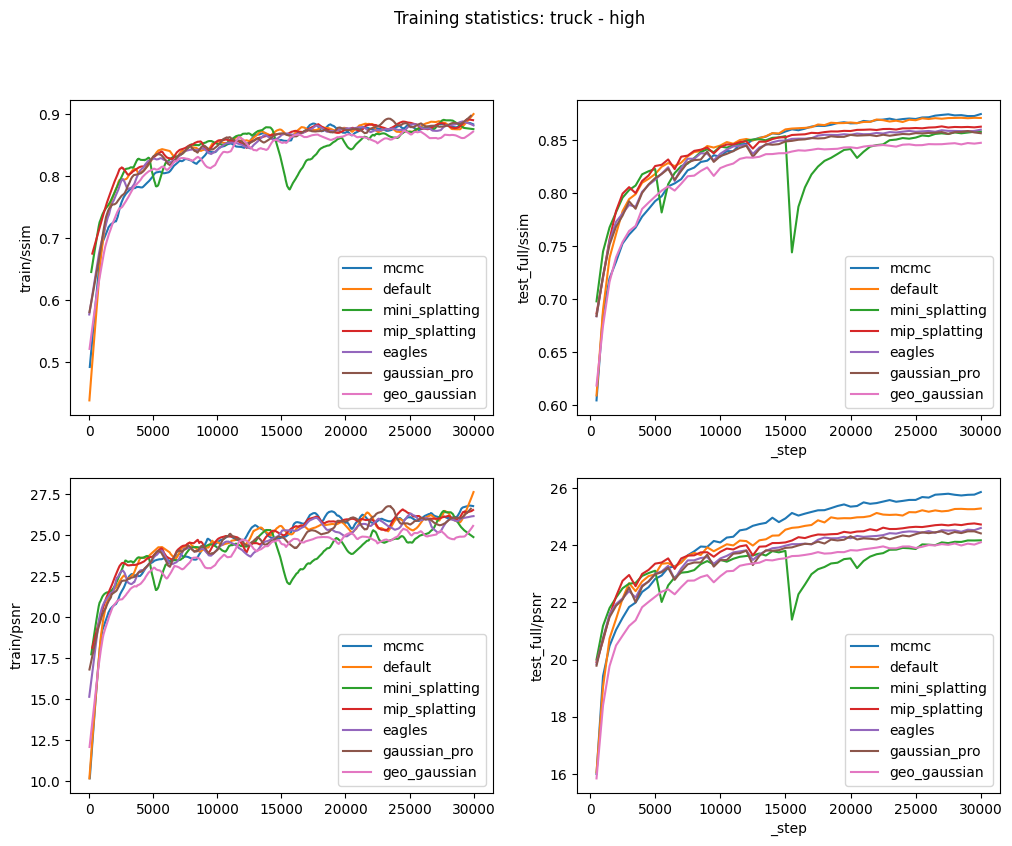

In [20]:
contrast_train_and_test_progress(df_training_stats, df_test_stats, "truck", "high")

### Contrast and compare room dataset

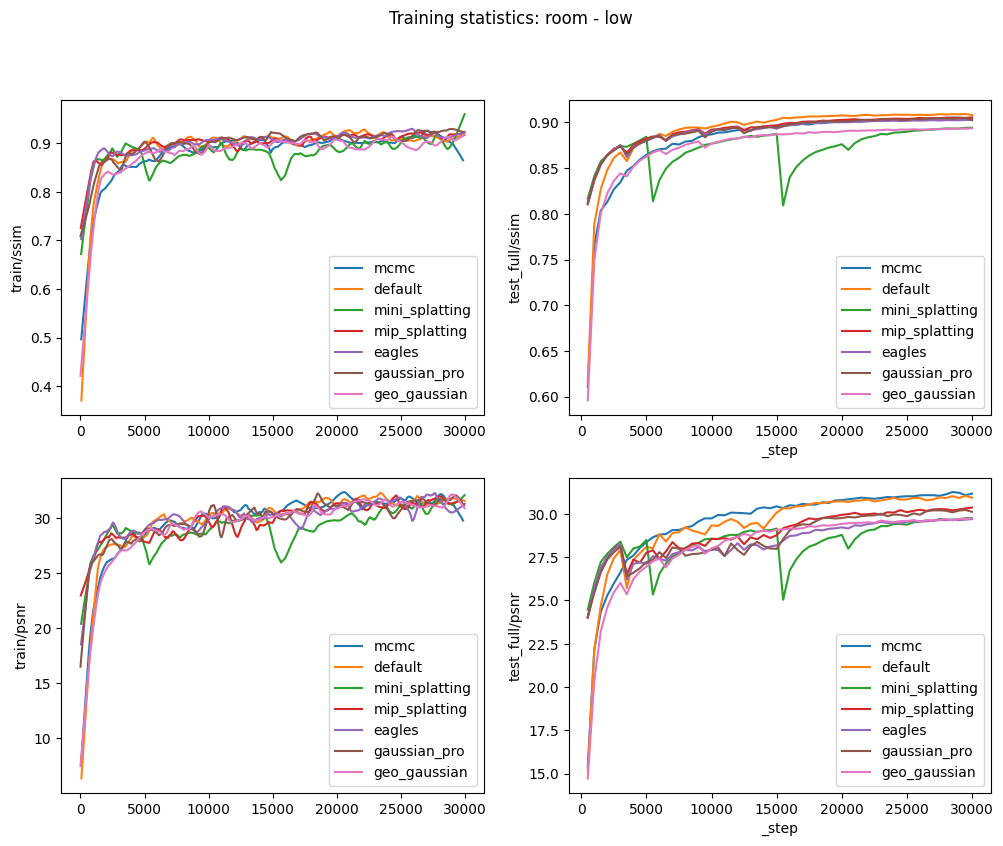

In [21]:
contrast_train_and_test_progress(df_training_stats, df_test_stats, "room", "low")

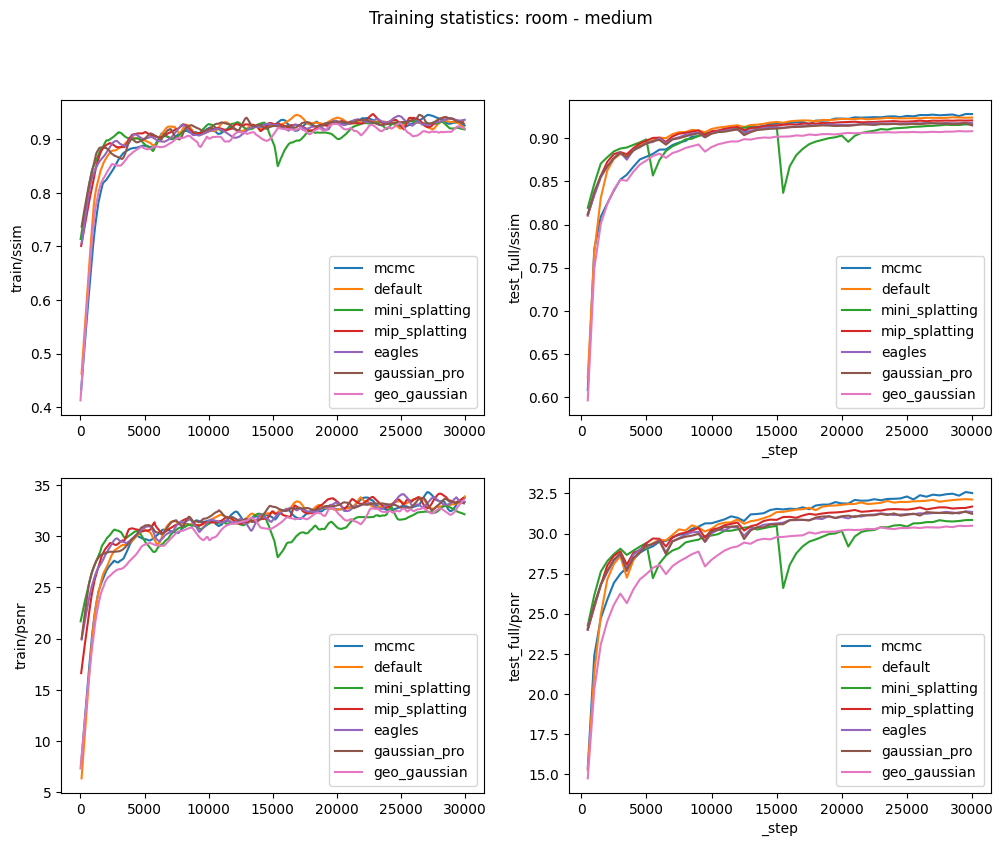

In [22]:
contrast_train_and_test_progress(df_training_stats, df_test_stats, "room", "medium")

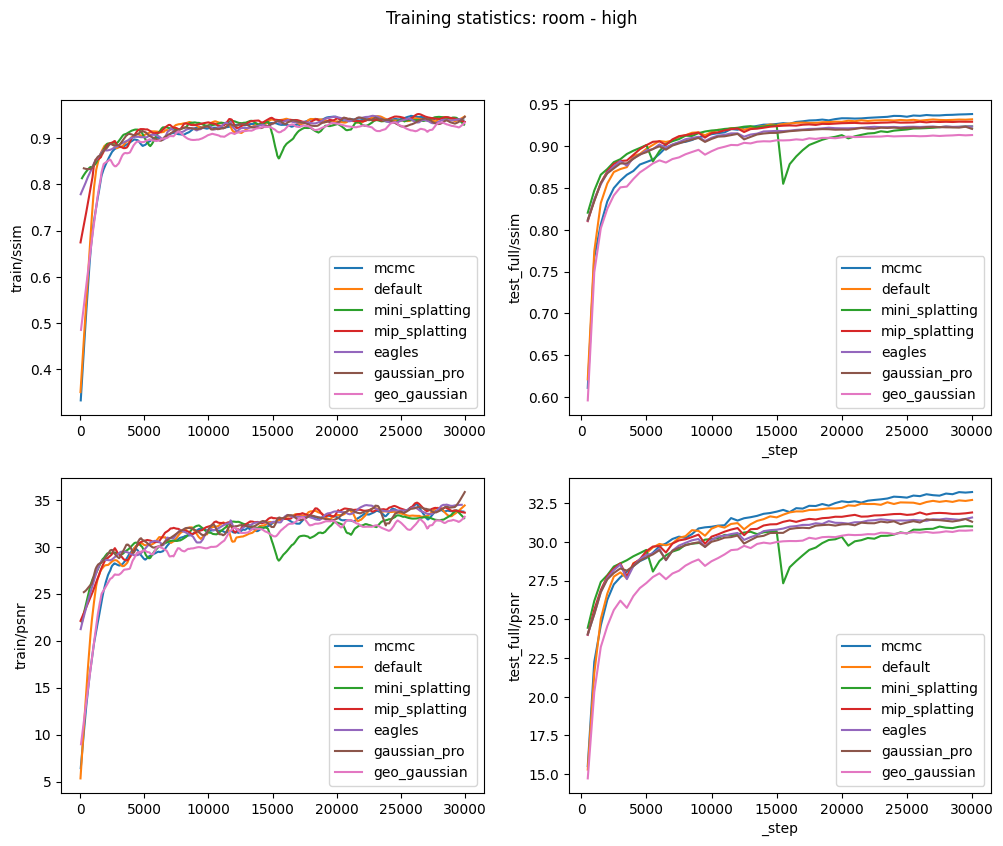

In [23]:
contrast_train_and_test_progress(df_training_stats, df_test_stats, "room", "high")

### Contrast and compare stump dataset

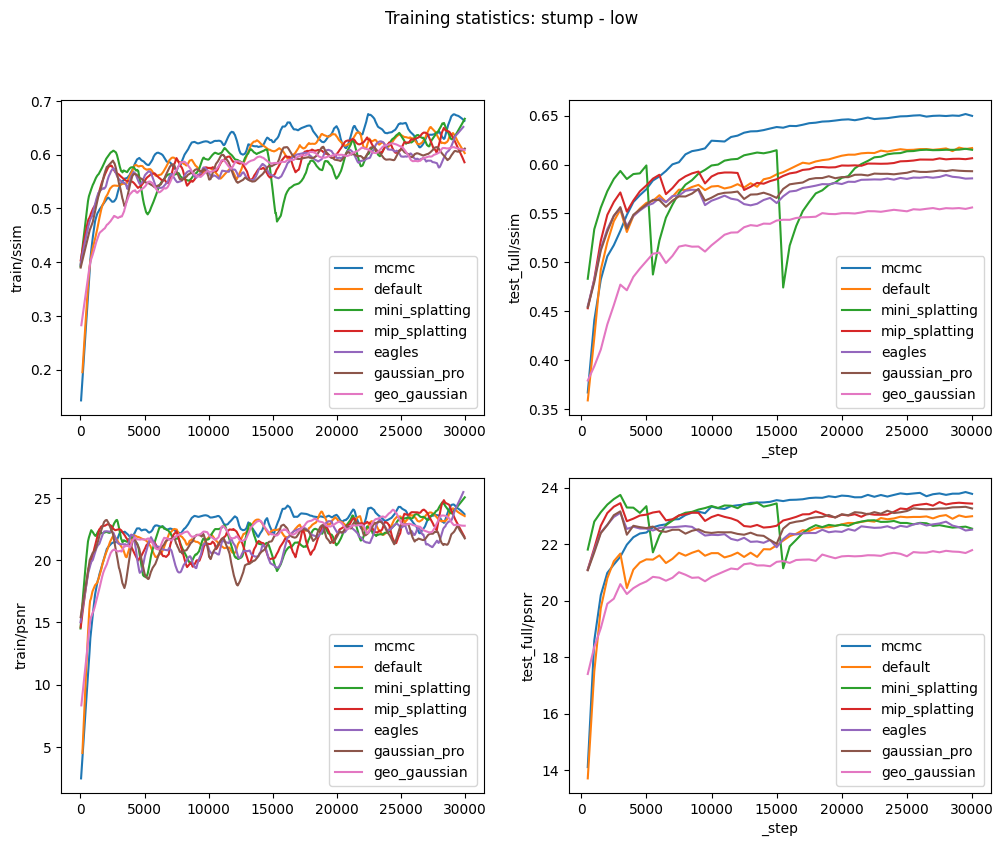

In [24]:
contrast_train_and_test_progress(df_training_stats, df_test_stats, "stump", "low")

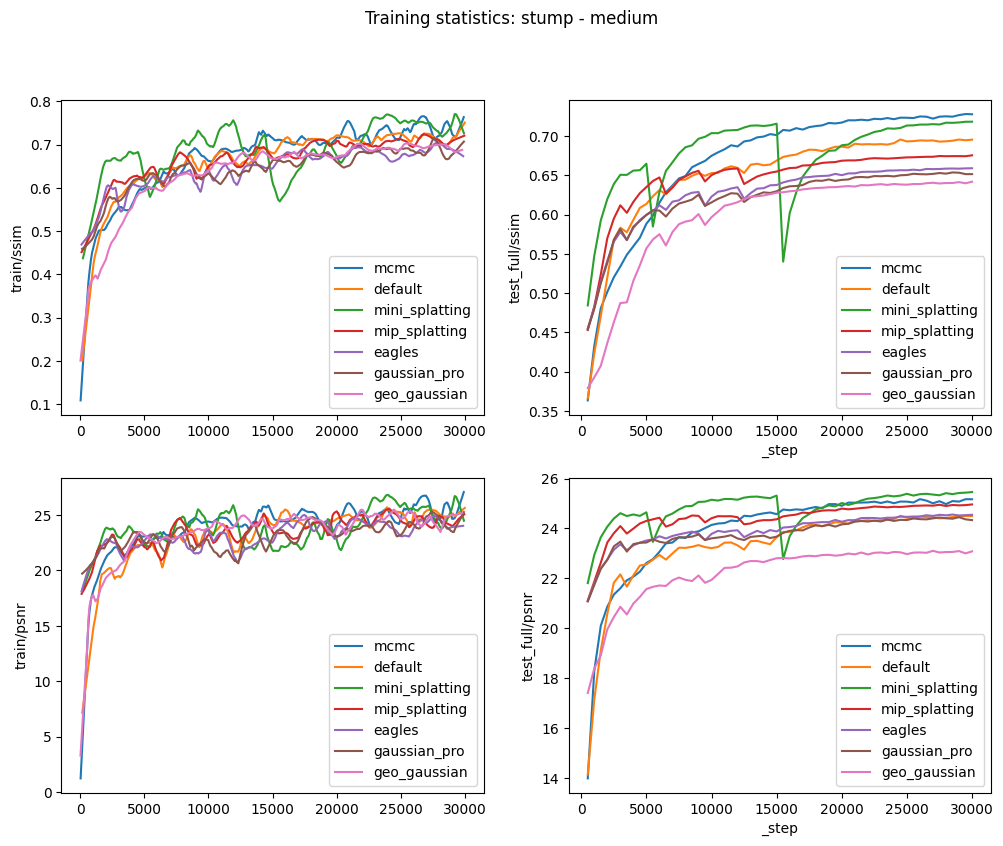

In [25]:
contrast_train_and_test_progress(df_training_stats, df_test_stats, "stump", "medium")

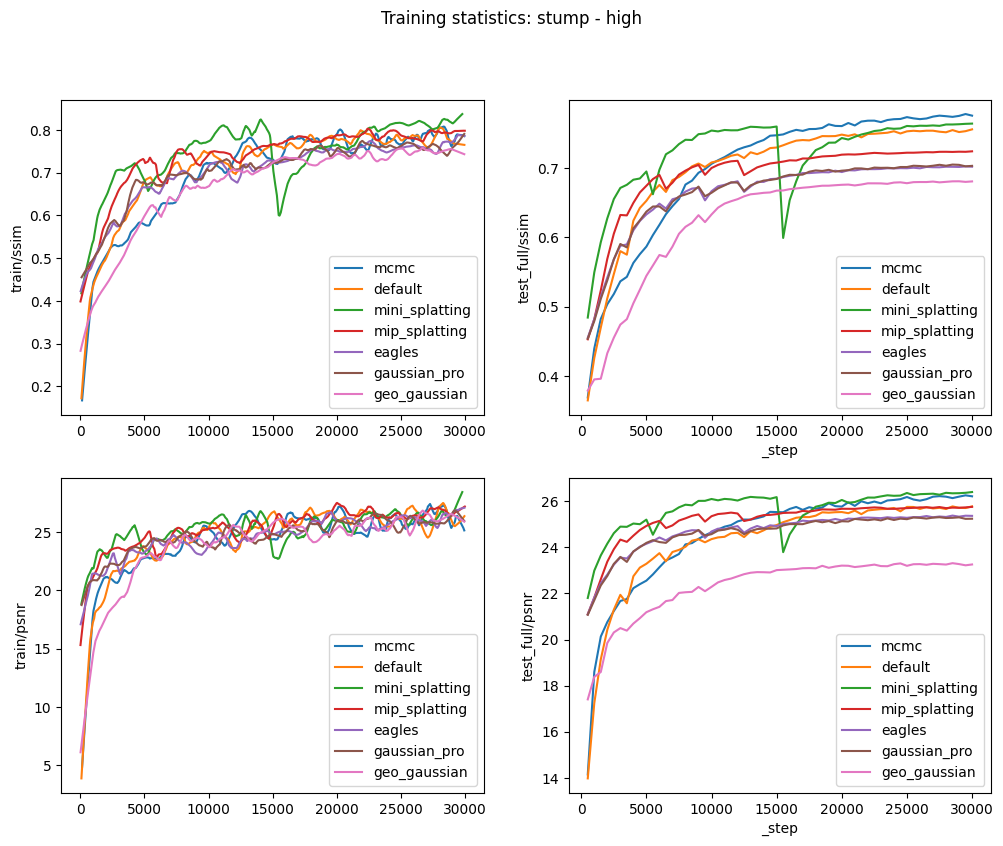

In [26]:
contrast_train_and_test_progress(df_training_stats, df_test_stats, "stump", "high")

### Condense training behavior into singular number...

In [27]:
def compute_difference_to_peak(df_test: pd.DataFrame) -> pd.DataFrame:
    records = []

    for technique in df_test["technique"].unique():
        for size in ["low", "medium", "high"]:
            for dataset in ["room", "stump", "truck"]:
                df_subset_self = df_test[
                    (df_test["technique"] == technique) &
                    (df_test["size"] == size) &
                    (df_test["dataset_name"] == dataset)
                ]
                df_subset_all = df_test[
                    (df_test["size"] == size) &
                    (df_test["dataset_name"] == dataset)
                ]
                records.append({
                    "technique": technique,
                    "size": size,
                    "dataset": dataset,
                    "diff_to_self_psnr": df_subset_self["test_full/psnr"].max() - df_subset_self["test_full/psnr"].iloc[-1],
                    "diff_to_best_psnr": df_subset_all["test_full/psnr"].max() - df_subset_self["test_full/psnr"].iloc[-1],
                    "diff_to_self_ssim": df_subset_self["test_full/ssim"].max() - df_subset_self["test_full/ssim"].iloc[-1],
                    "diff_to_best_ssim": df_subset_all["test_full/ssim"].max() - df_subset_self["test_full/ssim"].iloc[-1],
                    "technique": technique,
                })
    
    return pd.DataFrame.from_records(records)

In [28]:
df_diff_to_max = compute_difference_to_peak(df_test_stats)

In [29]:
df_diff_to_max

technique    size dataset  diff_to_self_psnr  diff_to_best_psnr  \
0           mcmc     low    room           0.088159           0.088159   
1           mcmc     low   stump           0.064834           0.064834   
2           mcmc     low   truck           0.042420           0.042420   
3           mcmc  medium    room           0.061119           0.061119   
4           mcmc  medium   stump           0.004829           0.289122   
..           ...     ...     ...                ...                ...   
58  geo_gaussian  medium   stump           0.021458           2.378058   
59  geo_gaussian  medium   truck           0.000000           1.528081   
60  geo_gaussian    high    room           0.000000           2.471386   
61  geo_gaussian    high   stump           0.056278           3.144536   
62  geo_gaussian    high   truck           0.000000           1.759528   

    diff_to_self_ssim  diff_to_best_ssim  
0            0.000238           0.004021  
1            0.001875           0.001875  
2            0.000596           0.000596  
3            0.000059           0.000059  
4            0.000286           0.000286  
..                ...                ...  
58           0.000000           0.086284  
59           0.000000           0.024324  
60           0.000104           0.025121  
61           0.000192           0.097066  
62           0.000000           0.027139  

[63 rows x 7 columns]

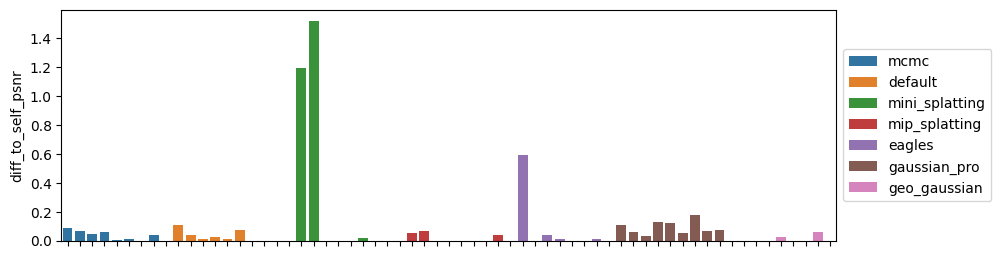

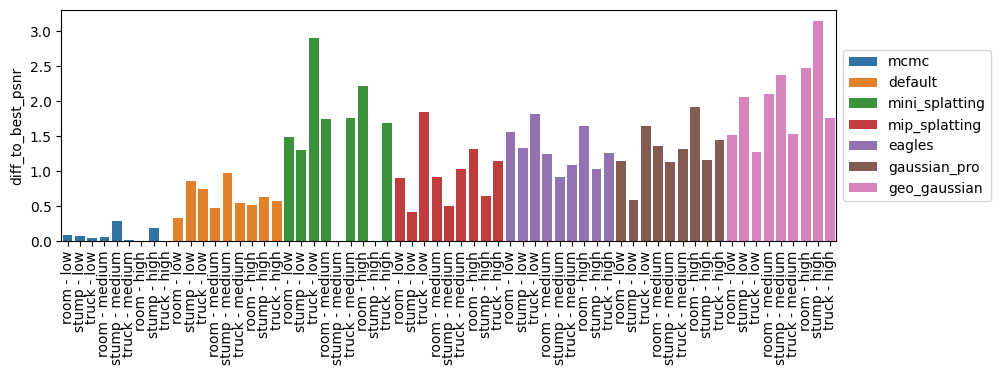

In [30]:
def visualize_diff_to_max(
    df_diff_to_max: pd.DataFrame, var="diff_to_self_psnr", show_ticks=True
):
    df_sorted = df_diff_to_max
    fig = plt.figure(figsize=(10, 3))
    sns.barplot(
        data=df_sorted,
        x=df_sorted.index,
        y=var,
        hue="technique",
        dodge=False,
    )
    if show_ticks:
        plt.xticks(
            ticks=range(len(df_sorted)),
            labels=df_sorted[["technique", "dataset", "size"]]
            .apply(tuple, axis=1)
            .apply(lambda x: f"{x[1]} - {x[2]}"),
            rotation=90,
        )
    else:
        plt.xticks(
            ticks=range(len(df_sorted)),
            labels=["" for _ in range(len(df_sorted))],
        )
    plt.xlabel("")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


visualize_diff_to_max(df_diff_to_max, "diff_to_self_psnr", show_ticks=False)
visualize_diff_to_max(df_diff_to_max, "diff_to_best_psnr")

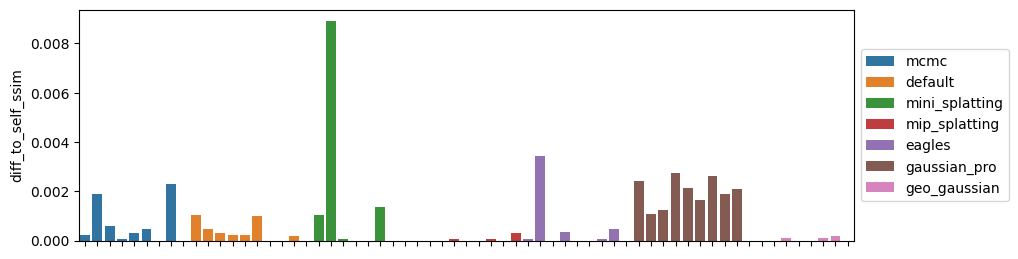

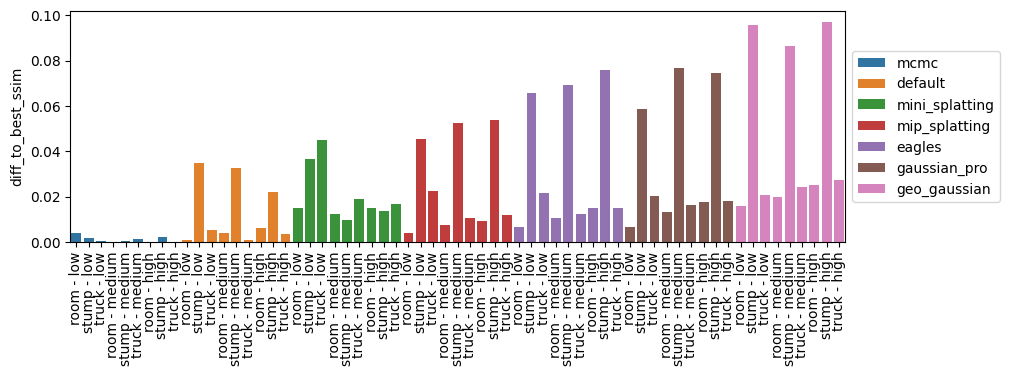

In [31]:
visualize_diff_to_max(df_diff_to_max, "diff_to_self_ssim", show_ticks=False)
visualize_diff_to_max(df_diff_to_max, "diff_to_best_ssim")

### Contrast densification behavior and test performance...

In [32]:
def contrast_densification_and_test_progress(
    df_train: pd.DataFrame, df_test: pd.DataFrame, dataset_name: str, size: str
) -> None:
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))
    plot_single_facet_curve(df_train, dataset_name, size, "cum_created", ax=axs[0][0])
    axs[0][0].legend().set_visible(False)
    axs[0][0].set_ylabel("cum_created")
    axs[0][0].set_xlabel(None)

    plot_single_facet_curve(
        df_train, dataset_name, size, "cum_deleted", smooth_frac=0.05, ax=axs[0][1]
    )
    axs[0][1].legend().set_visible(False)
    axs[0][1].set_ylabel("cum_deleted")
    axs[0][1].set_xlabel(None)

    plot_single_facet_curve(df_train, dataset_name, size, "n_gaussians", ax=axs[1][0])
    axs[1][0].legend().set_visible(False)
    axs[1][0].set_ylabel("n_gaussians")
    axs[1][0].set_xlabel("step")

    plot_single_facet_curve(df_test, dataset_name, size, "test_full/ssim", ax=axs[1][1])
    axs[1][1].legend().set_visible(False)
    axs[1][1].set_ylabel("test_full/ssim")
    axs[1][1].set_xlabel("step")

    fig.suptitle(f"Densification statistics: {dataset_name} - {size}")
    lines, labels = axs[1][1].get_legend_handles_labels()
    fig.legend(lines, labels, loc="center left", ncol=2, bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

### Contrast densification of behavior of truck dataset...

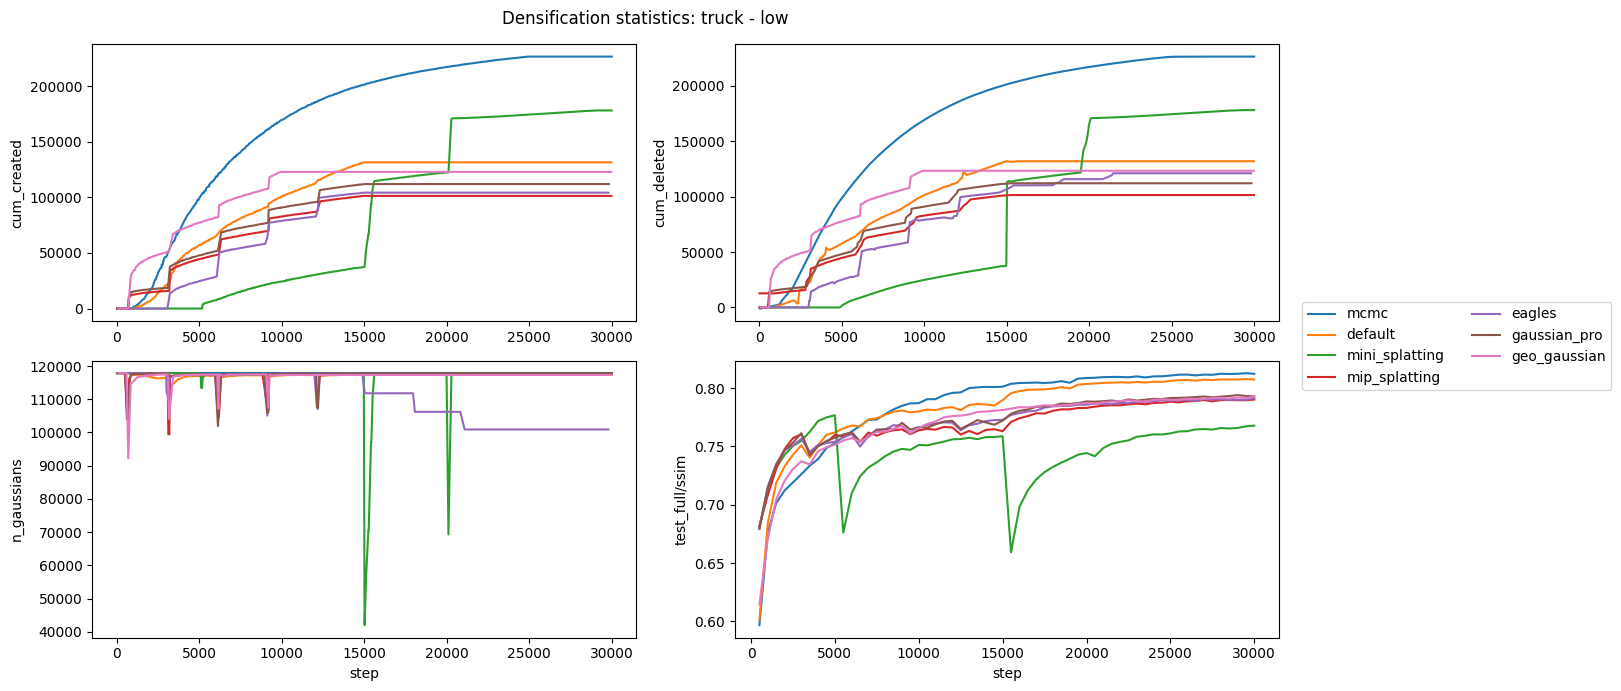

In [33]:
contrast_densification_and_test_progress(
    df_training_stats, df_test_stats, "truck", "low"
)

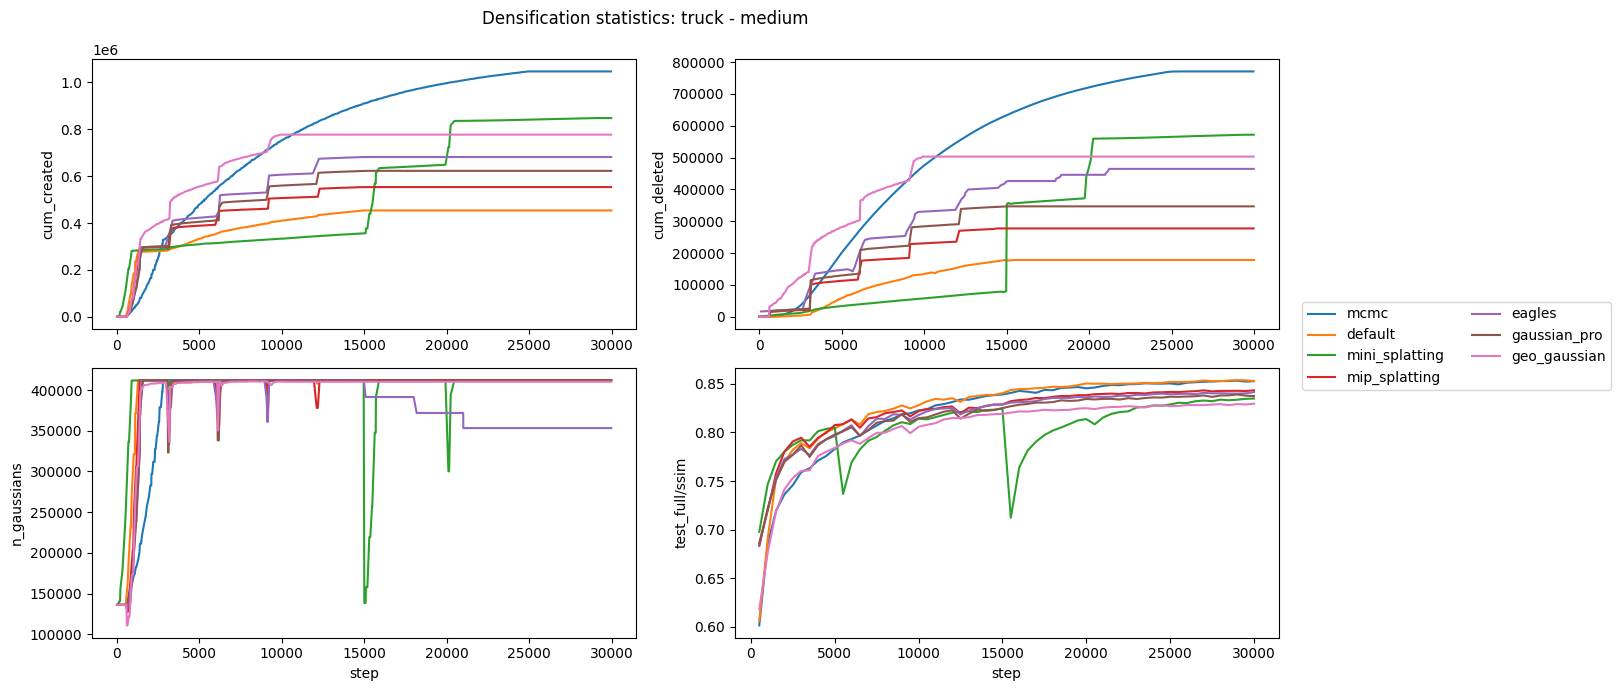

In [34]:
contrast_densification_and_test_progress(
    df_training_stats, df_test_stats, "truck", "medium"
)

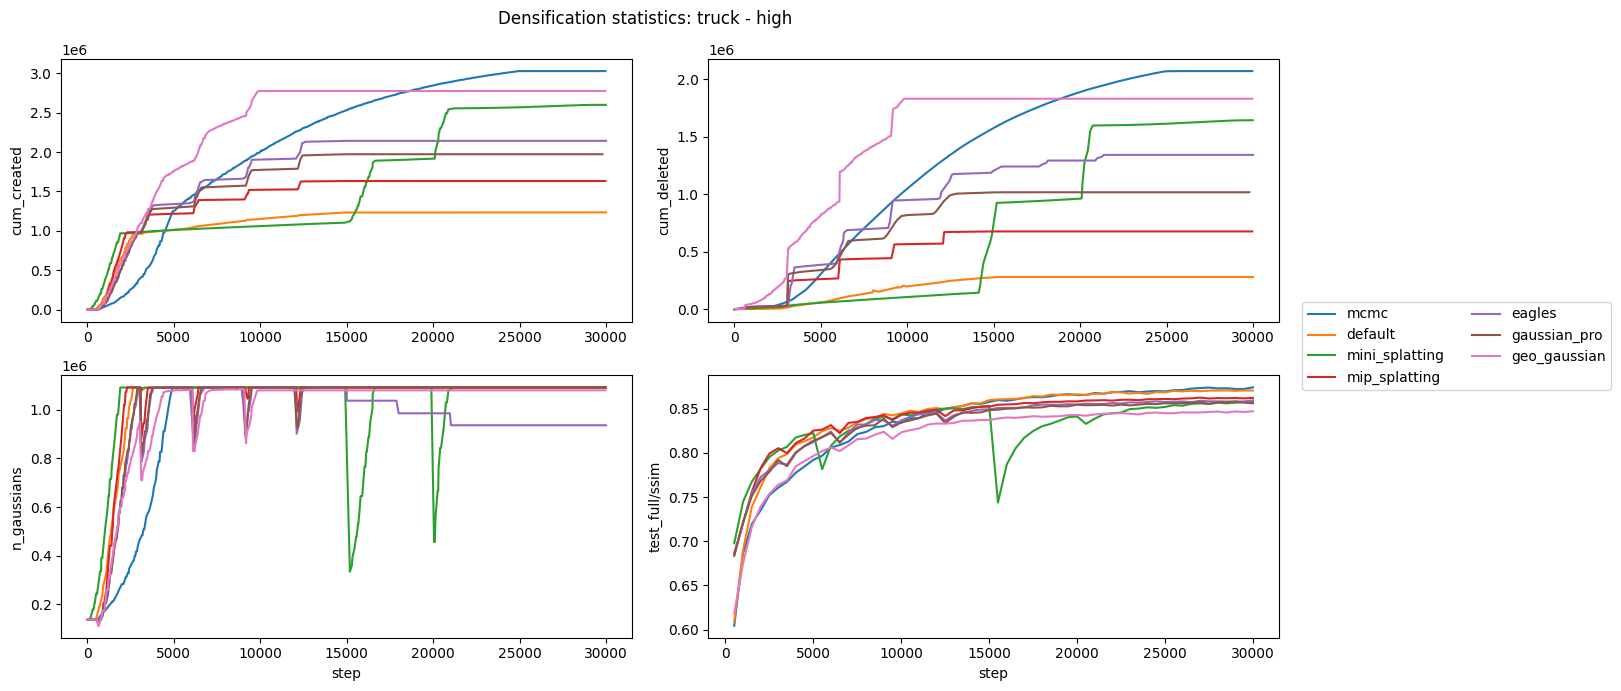

In [35]:
contrast_densification_and_test_progress(
    df_training_stats, df_test_stats, "truck", "high"
)

### Contrast densification of room dataset...

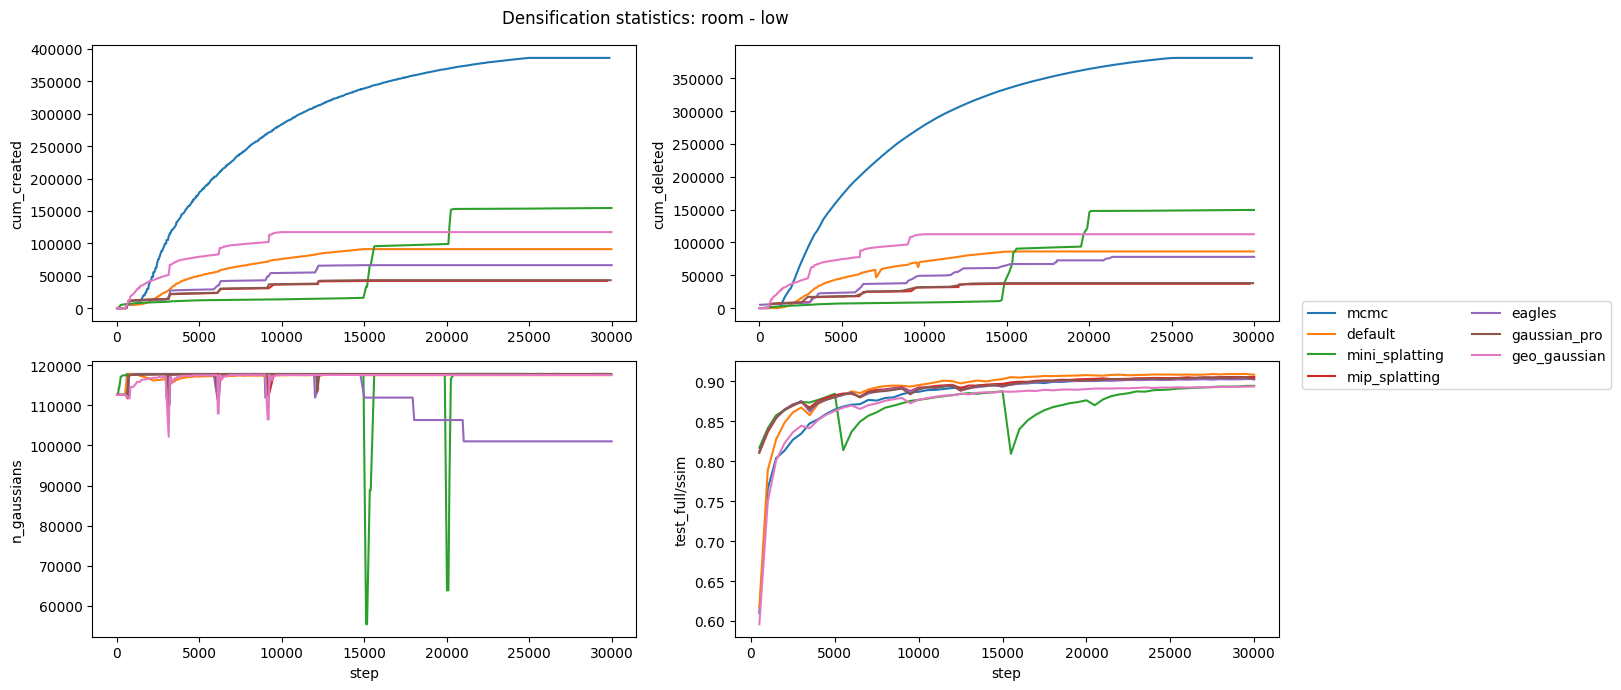

In [36]:
contrast_densification_and_test_progress(
    df_training_stats, df_test_stats, "room", "low"
)

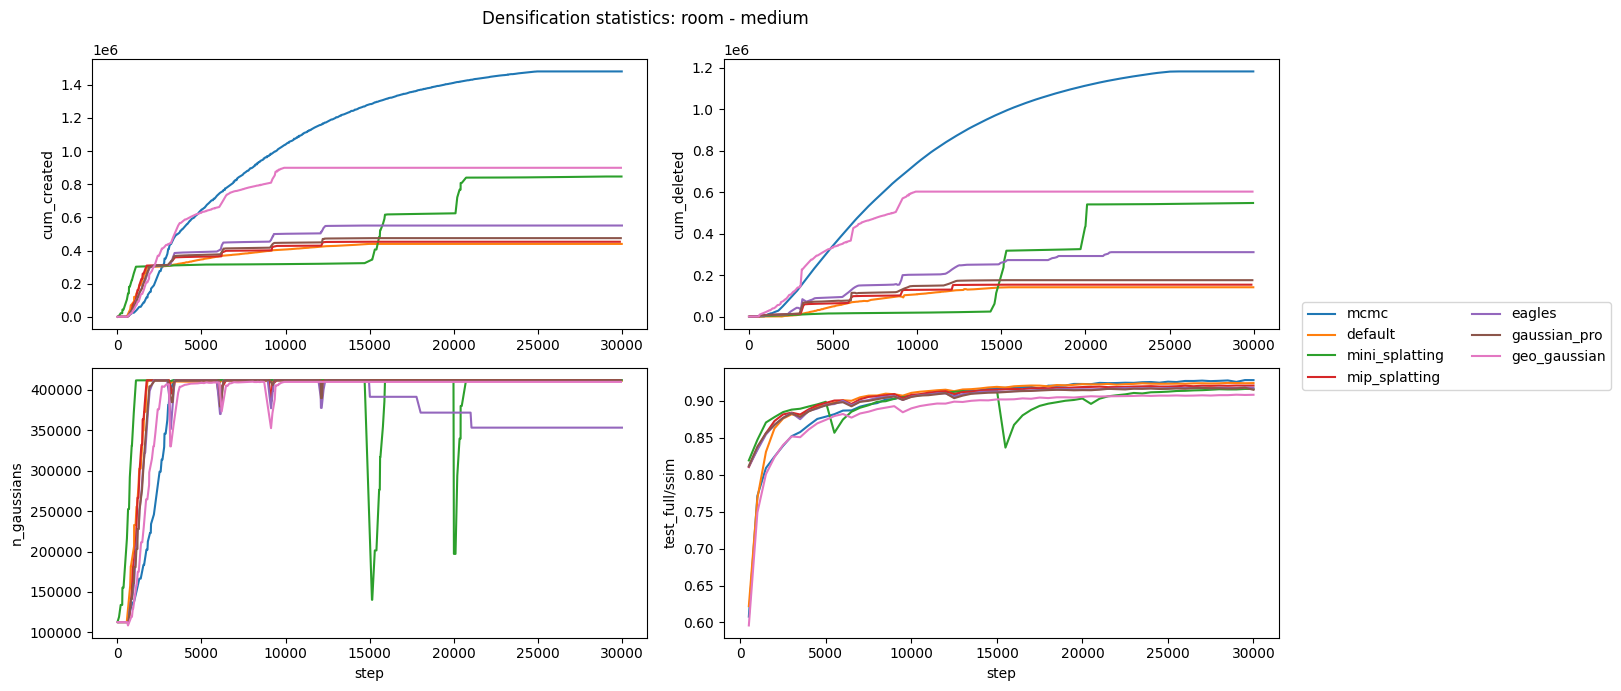

In [37]:
contrast_densification_and_test_progress(
    df_training_stats, df_test_stats, "room", "medium"
)

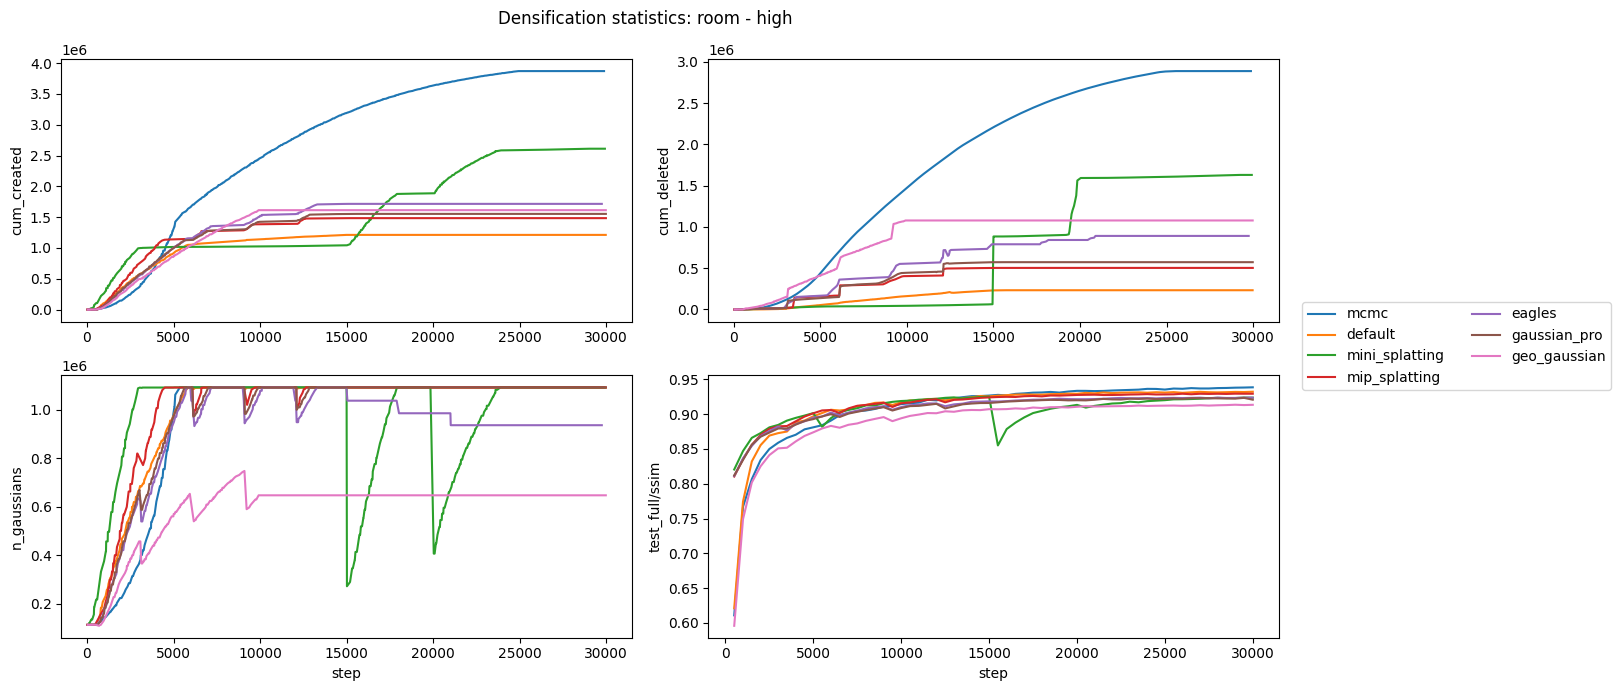

In [38]:
contrast_densification_and_test_progress(
    df_training_stats, df_test_stats, "room", "high"
)

### Contrast densification behavior of stump dataset...

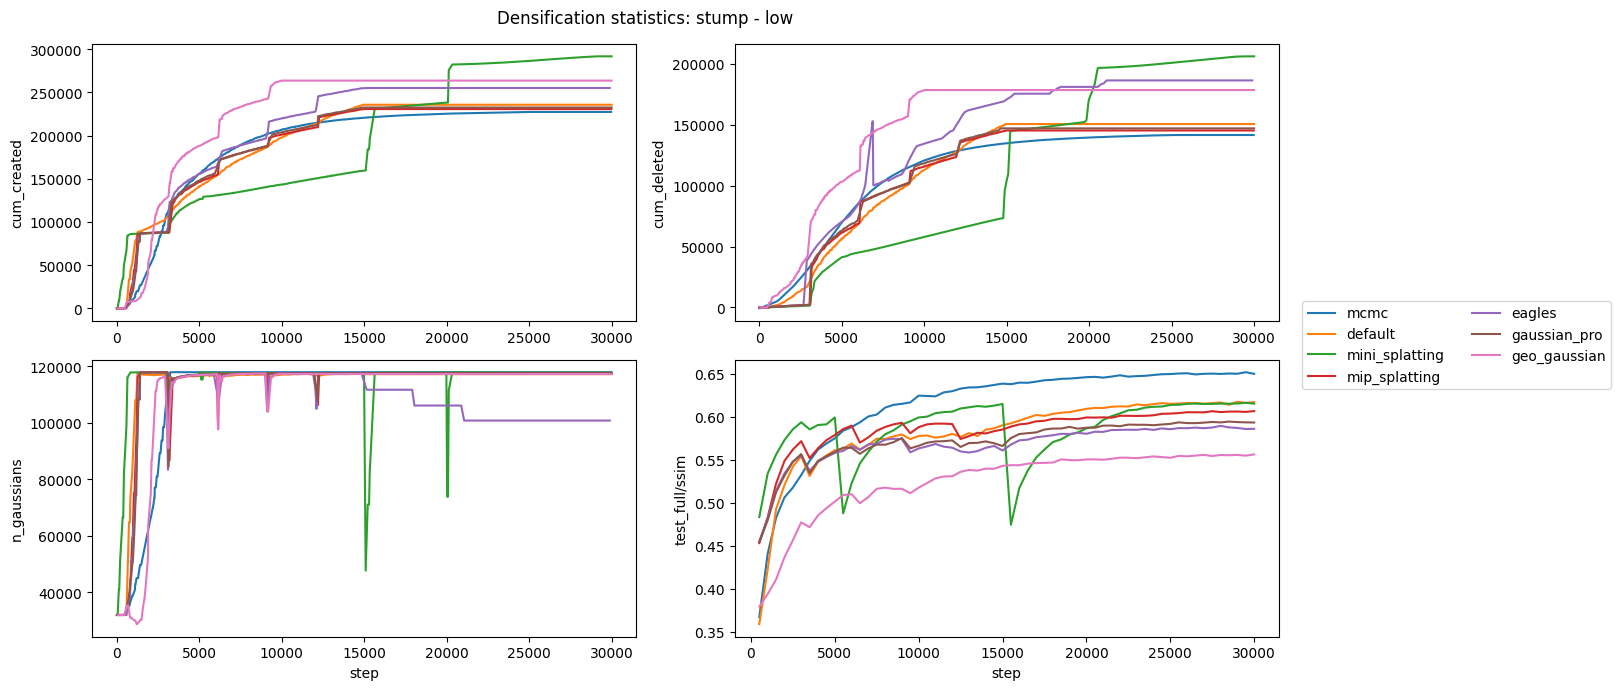

In [39]:
contrast_densification_and_test_progress(
    df_training_stats, df_test_stats, "stump", "low"
)

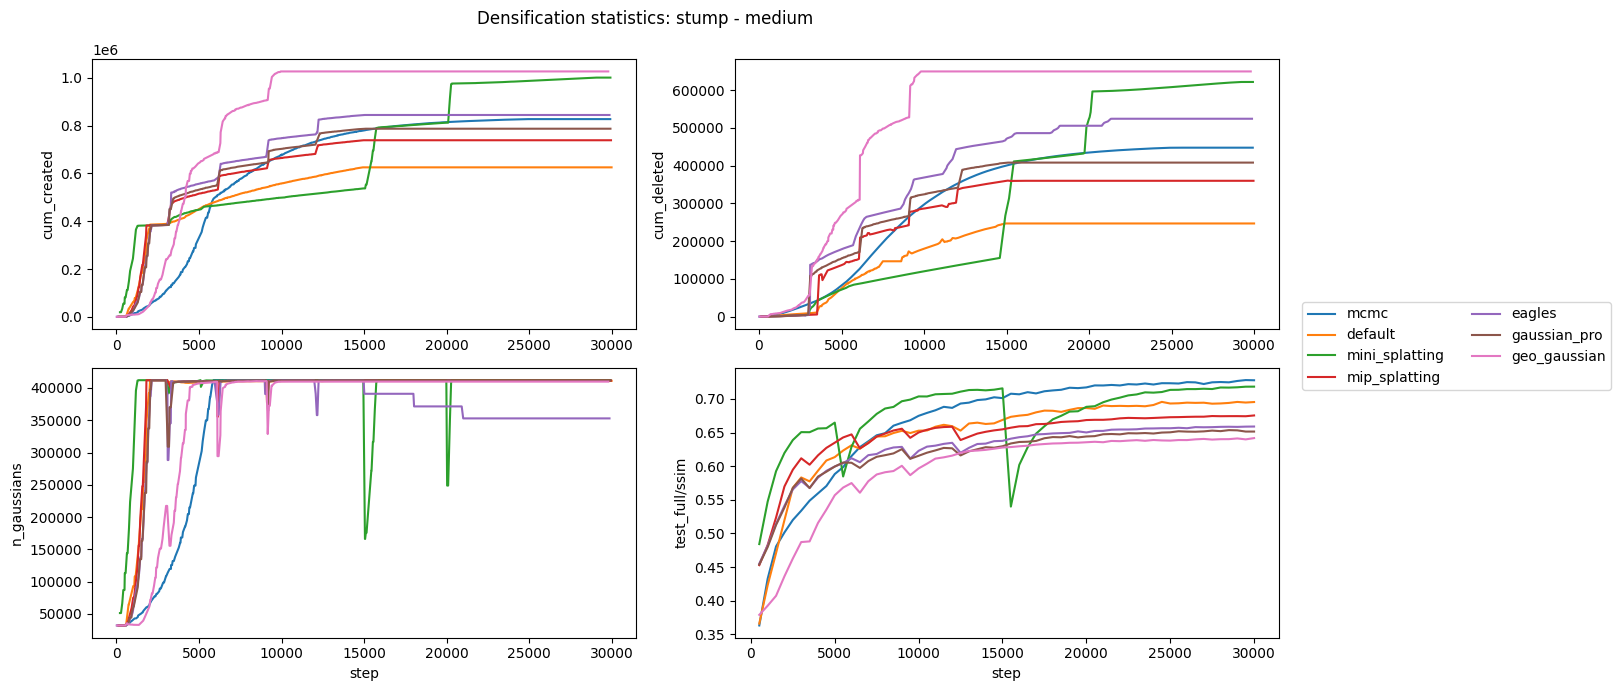

In [40]:
contrast_densification_and_test_progress(
    df_training_stats, df_test_stats, "stump", "medium"
)

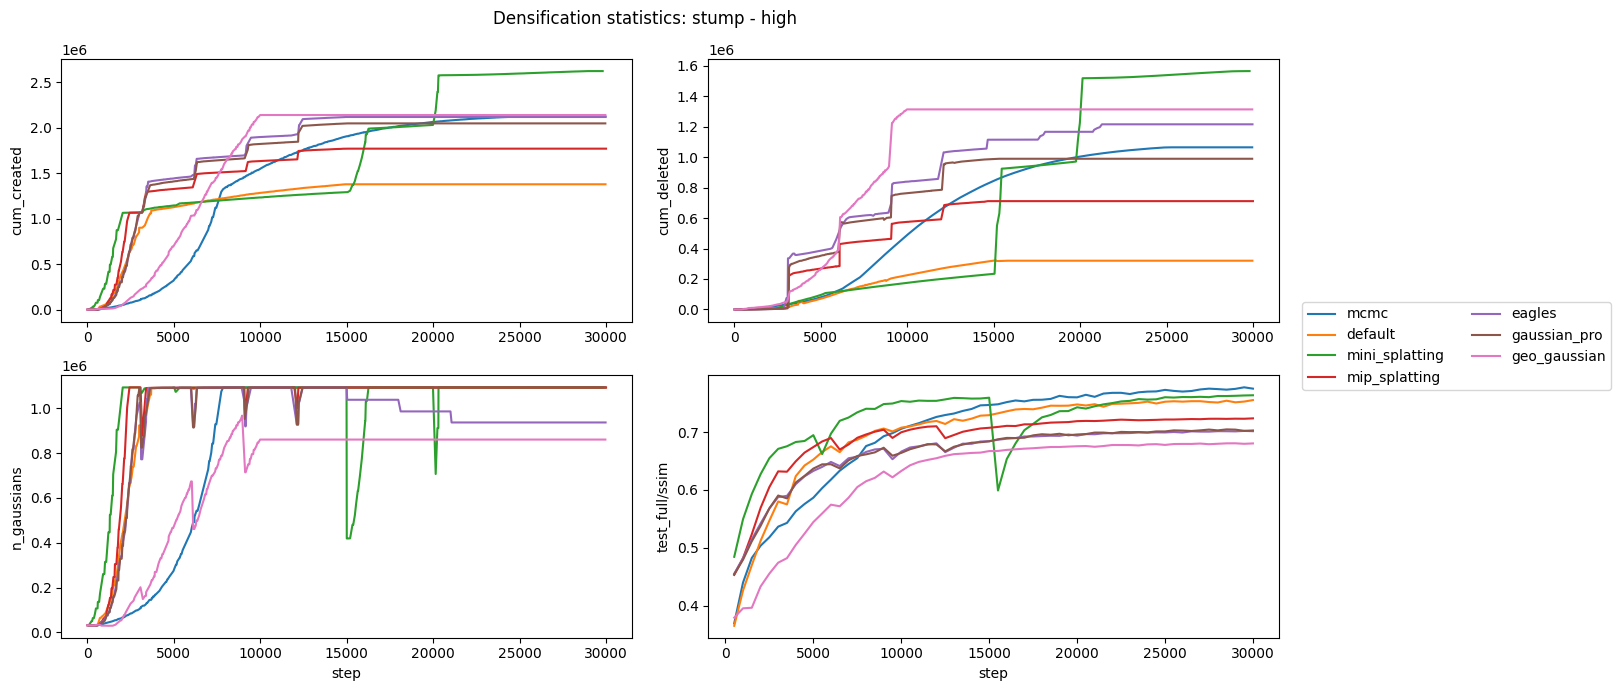

In [41]:
contrast_densification_and_test_progress(
    df_training_stats, df_test_stats, "stump", "high"
)